# Определение возраста покупателей

In [1]:
# подгружаем библиотеки
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from PIL import Image

## Исследовательский анализ данных

In [2]:
# открываем файл
df = pd.read_csv('/datasets/faces/labels.csv')

# извлекаем данные
train_datagen = ImageDataGenerator(rescale=1./255)
train_gen_flow = train_datagen.flow_from_dataframe(
        dataframe=df,
        directory='/datasets/faces/final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(150, 150),
        batch_size=16,
        class_mode='raw',
        seed=12345)

Found 7591 validated image filenames.


In [3]:
# смотрим на размер выборки
df.shape[0]

7591

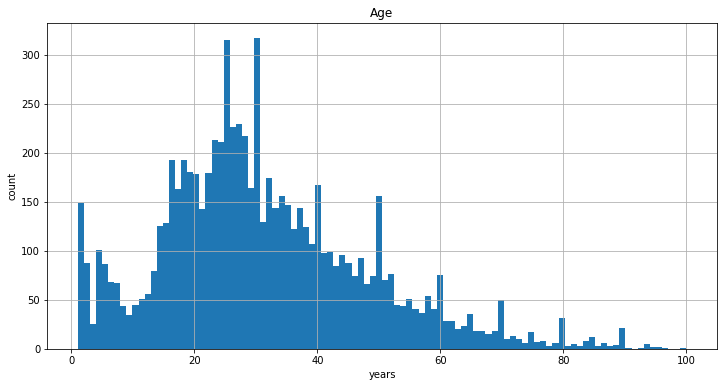

In [4]:
# смотрим на распределение возрастов
df['real_age'].hist(bins=100, figsize=(12,6))
plt.title('Age');
plt.xlabel('years');
plt.ylabel('count');

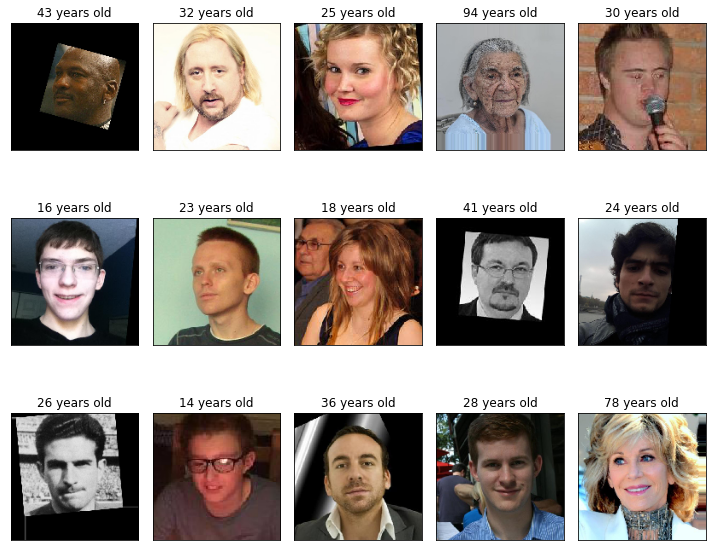

In [7]:
# посмотрим на 15 изображений
features, target = next(train_gen_flow)

fig = plt.figure(figsize=(10,10))
for i in range(15):
    fig.add_subplot(3, 5, i+1)
    plt.imshow(features[i])
    plt.xticks([])
    plt.yticks([])
    plt.tight_layout()
    plt.title(str(target[i]) + ' years old')

In [6]:
# посмотрим на основную информацию о датасете
df.info()
df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7591 entries, 0 to 7590
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   file_name  7591 non-null   object
 1   real_age   7591 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 118.7+ KB


,real_age
count,7591.000000
mean,31.201159
std,17.145060
min,1.000000
25%,20.000000
50%,29.000000
75%,41.000000
max,100.000000


**Вывод
<br>1) В наборе имеется 7591 фотография, не большая выборка для подобной задачи, да и фото не идеальны, в плане вида лица (жвачка, микрофон, очки итд)
<br>2) Преимущественно в них харанится по российским меркам молодежь (от 20 до 40 лет)
<br>3) Данные распределены нормально**

## Обучение модели

Перенесите сюда код обучения модели и её результат вывода на экран.


(Код в этом разделе запускается в отдельном GPU-тренажёре, поэтому оформлен не как ячейка с кодом, а как код в текстовой ячейке)

```python

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Conv2D, Flatten, Dense, MaxPooling2D, AvgPool2D, Dropout, GlobalAveragePooling2D
from tensorflow.keras.applications.resnet import ResNet50
import pandas as pd

def load_train(path):
    labels = pd.read_csv(path + 'labels.csv')
    train_datagen = ImageDataGenerator(
                                    validation_split=0.25,
                                    rescale=1./255,
                                    horizontal_flip=True)
    train_datagen_flow = train_datagen.flow_from_dataframe(
      dataframe=labels,
      directory=path + 'final_files/',
      x_col='file_name',
      y_col='real_age',
      target_size=(224, 224),
      batch_size=16,
      class_mode='raw',
      subset='training',
      seed=12345)

    return train_datagen_flow

def load_test(path):
    labels = pd.read_csv(path + 'labels.csv')
    test_datagen = ImageDataGenerator(
                                    validation_split=0.25,
                                    rescale=1./255)

    test_gen_flow = test_datagen.flow_from_dataframe(
      dataframe=labels,
      directory=path + 'final_files/',
      x_col='file_name',
      y_col='real_age',
      target_size=(224, 224),
      batch_size=16,
      class_mode='raw',
      subset='validation',
      seed=12345)

    return test_gen_flow

def create_model(input_shape): 
    optimizer = Adam(learning_rate = 0.0003)
    backbone = ResNet50(input_shape=input_shape, weights='/datasets/keras_models/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5', include_top=False) 
 
    model = Sequential() 
 
    model.add(backbone) 
    model.add(GlobalAveragePooling2D()) 
    model.add(Dense(1, activation='relu')) 
 
    model.compile(optimizer=optimizer, loss='mean_squared_error', metrics=['mae']) 
 
    return model

def train_model(model, train_data, test_data, batch_size=None, epochs=10,
                steps_per_epoch=None, validation_steps=None):
    model.fit(train_data,
              validation_data=test_data,
              batch_size=batch_size, epochs=epochs,
              steps_per_epoch=steps_per_epoch,
              validation_steps=validation_steps,
              verbose=2)

    return model

```

```

Found 5694 validated image filenames.
Found 1897 validated image filenames.

<class 'tensorflow.python.keras.engine.sequential.Sequential'>

Train for 356 steps, validate for 119 steps
Epoch 1/10
356/356 - 114s - loss: 204.8660 - mae: 10.4056 - val_loss: 632.3849 - val_mae: 20.0877
Epoch 2/10
356/356 - 41s - loss: 87.3944 - mae: 7.0922 - val_loss: 123.1090 - val_mae: 8.2698
Epoch 3/10
356/356 - 41s - loss: 56.3617 - mae: 5.7558 - val_loss: 83.0355 - val_mae: 6.7989
Epoch 4/10
356/356 - 41s - loss: 41.4288 - mae: 4.9632 - val_loss: 98.0594 - val_mae: 7.4277
Epoch 5/10
356/356 - 41s - loss: 31.8802 - mae: 4.3635 - val_loss: 70.8377 - val_mae: 6.3042
Epoch 6/10
356/356 - 41s - loss: 26.1412 - mae: 3.9406 - val_loss: 74.3797 - val_mae: 6.3822
Epoch 7/10
356/356 - 41s - loss: 21.7432 - mae: 3.5440 - val_loss: 92.1918 - val_mae: 7.1217
Epoch 8/10
356/356 - 41s - loss: 19.7696 - mae: 3.3835 - val_loss: 67.2342 - val_mae: 6.1477
Epoch 9/10
356/356 - 41s - loss: 15.3840 - mae: 3.0008 - val_loss: 74.9610 - val_mae: 6.4470
Epoch 10/10
356/356 - 41s - loss: 14.0712 - mae: 2.8653 - val_loss: 66.8269 - val_mae: 6.0457

119/119 - 10s - loss: 66.8269 - mae: 6.0457
Test MAE: 6.0457

```

**Вывод
<br>1) Посмтроена модель сверточной нейронной сети ResNet50 
<br>2) За 10 эпох MAE удалось кменьшить до 2.8 на тренировочной выборке**

## Анализ обученной модели

**Обученная модель с высокой точностью определяет возраст покупателей. MAE = 6, что не слишком большая погрешность для покупателей, поскольку их всё равно определяют интревалами (20-25, 26-32 идт)
<br>Что для бизнеса в свою очередь тоже хорошо, поскольку данного диапазона погрешности в возрасте достаточно, что бы как минимум была возможность определять возрастные категории покупок опеделенных товаров и на основе их либо организовывать определенное расположение товаров, а так же высоту расположения и тд, или же устраивать оазличные промо акции**